In [11]:
from PIL import Image
import numpy as np
import torch
from torch import nn, optim
from p5a import ReducingresolutionClass
from model_resolution import MLP, device
import matplotlib.pyplot as plt
from p5c import eval_resolution

In [12]:
# Load the images
images = [Image.open(f'{i}.jpg') for i in range(1, 11)]
reducing = ReducingresolutionClass(n=2)
features2, labels2, end_of_each_image2, low_res_images2 =  reducing.reduce(images)
list_features = features2
features = np.array(features2)
labels = np.array(labels2)

# Split the dataset into training, validation, and test sets
train_features, train_labels = features[:end_of_each_image2[7]], labels[:end_of_each_image2[7]]
val_features, val_labels = features[end_of_each_image2[7]:end_of_each_image2[8]], labels[end_of_each_image2[7]:end_of_each_image2[8]]
test_features, test_labels = features[end_of_each_image2[8]:], labels[end_of_each_image2[8]:]

In [13]:
reducing = ReducingresolutionClass(n=4)
features4, labels4, end_of_each_image4, low_res_images4 =  reducing.reduce(images)
list_features4 = features4
features4 = np.array(features4)
labels4 = np.array(labels4)

# Split the dataset into training, validation, and test sets
train_features4, train_labels4 = features[:end_of_each_image4[7]], labels[:end_of_each_image4[7]]
val_features4, val_labels4 = features[end_of_each_image4[7]:end_of_each_image4[8]], labels[end_of_each_image4[7]:end_of_each_image4[8]]
test_features4, test_labels4 = features[end_of_each_image4[8]:], labels[end_of_each_image4[8]:]

In [14]:
modelb = MLP().to(device)
modelb.load_state_dict(torch.load('model_part_b.pth', map_location=device))

# Generate high resolution twice construction with network from part b
high_res_images_with_two_construction = []
for i in end_of_each_image4.keys():
    if i > 1:
        low_res_image_np = features[end_of_each_image4[i-1]:end_of_each_image4[i]]
    else:
        low_res_image_np = features[0:end_of_each_image4[1]]# Convert PIL Image to numpy array
    low_res_image_tensor = torch.tensor(low_res_image_np, dtype=torch.float32, requires_grad=True).to(device)
    high_res_image_b = modelb(modelb(low_res_image_tensor)).cpu().detach().numpy()
    high_res_images_with_two_construction.append(high_res_image_b)

RuntimeError: Error(s) in loading state_dict for MLP:
	Unexpected key(s) in state_dict: "layers.6.weight", "layers.6.bias", "layers.8.weight", "layers.8.bias", "layers.10.weight", "layers.10.bias". 
	size mismatch for layers.2.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layers.4.weight: copying a param with shape torch.Size([256, 128]) from checkpoint, the shape in current model is torch.Size([3, 32]).
	size mismatch for layers.4.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([3]).

In [ ]:
modeld = MLP().to(device)
# Check if a GPU is available and if not, use a CPU
from model_resolution import MLP, device
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(modeld.parameters())

# Convert the datasets to PyTorch tensors and move them to the appropriate device
train_features = torch.tensor(train_features4, dtype=torch.float32, requires_grad=True).to(device)
train_labels = torch.tensor(train_labels4, dtype=torch.float32, requires_grad=True).to(device)
val_features = torch.tensor(val_features4, dtype=torch.float32, requires_grad=True).to(device)
val_labels = torch.tensor(val_labels4, dtype=torch.float32, requires_grad=True).to(device)

Epoch 1/100 - Training Loss: 12742.6357421875
Epoch 1/100 - Validation Loss: 7509.86669921875
Epoch 2/100 - Training Loss: 12075.4521484375
Epoch 2/100 - Validation Loss: 7171.30859375
Epoch 3/100 - Training Loss: 11496.9462890625
Epoch 3/100 - Validation Loss: 6828.75048828125


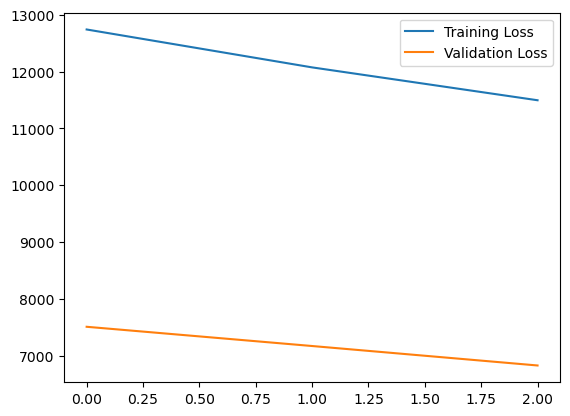

In [6]:
# Initialize lists to store the losses
train_losses = []
val_losses = []

# Train the MLP
for epoch in range(1000):  # 100 epochs
    modeld.train()  # Set the model to training mode
    optimizer.zero_grad()  # Reset the gradients
    train_outputs = modeld(train_features)  # Forward pass
    loss = criterion(train_outputs, train_labels)  # Compute the loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights

    # Store the training loss
    train_losses.append(loss.item())

    # Print the loss for this epoch
    print(f'Epoch {epoch+1}/{100} - Training Loss: {loss.item()}')

    # Validate the MLP
    modeld.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track the gradients
        val_outputs = modeld(val_features)  # Forward pass
        val_loss = criterion(val_outputs, val_labels)  # Compute the loss

        # Store the validation loss
        val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            # Print the validation loss
            print(f'Epoch {epoch+1}/{100} - Validation Loss: {val_loss.item()}')

# Plot the learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [10]:
# Save the model
torch.save(modeld.state_dict(), 'model_part_d.pth', )

In [7]:
# Convert the test dataset to PyTorch tensors and move them to the appropriate device
test_features = torch.tensor(test_features4, dtype=torch.float32, requires_grad=True).to(device)
test_labels = torch.tensor(test_labels4, dtype=torch.float32, requires_grad=True).to(device)
# Calculate the error function value for the test dataset
model = MLP().to(device)
model.load_state_dict(torch.load('model_part_d.pth'))
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track the gradients
    test_outputs = model(test_features)  # Forward pass
    test_loss = criterion(test_outputs, test_labels)  # Compute the loss

# Print the test loss
print(f'Test Loss: {test_loss.item()}')

# Generate high-resolution images
high_res_images = []
for i in end_of_each_image4.keys():
    if i > 1:
        low_res_image_np = features[end_of_each_image4[i-1]:end_of_each_image4[i]]
    else:
        low_res_image_np = features[0:end_of_each_image4[1]]# Convert PIL Image to numpy array
    low_res_image_tensor = torch.tensor(low_res_image_np, dtype=torch.float32, requires_grad=True).to(device)
    high_res_image = model(low_res_image_tensor).cpu().detach().numpy()
    high_res_images.append(high_res_image)

Test Loss: 7438.09130859375


In [8]:
# Convert the numpy array to integer type
high_res_images_quantized = []
for i, (high_res_img, img) in enumerate(zip(high_res_images, images)):
    high_res_img = high_res_img.reshape(img.height, img.width, 3).astype(np.uint8)
    high_res_image_ = high_res_img.astype(np.uint8)
    high_res_images_quantized.append(high_res_image_)

# Convert the numpy array to a PIL Image
high_res_images_pil = [Image.fromarray(img).convert('RGB') for img in high_res_images_quantized]

In [9]:
eval_resolution(high_res_images, images)

Image 1 - SSIM: 0.11078283272878467, PSNR: 7.993947685545485
Image 2 - SSIM: 0.0437172949962245, PSNR: 6.075913954673551
Image 3 - SSIM: 0.16933776871287662, PSNR: 12.03317995734081
Image 4 - SSIM: 0.2263063402170994, PSNR: 11.140039479870618
Image 5 - SSIM: 0.01933408587418855, PSNR: 4.373896541974439
Image 6 - SSIM: 0.13233170060031005, PSNR: 10.298494218472197
Image 7 - SSIM: 0.08216822514732386, PSNR: 5.845945249596566
Image 8 - SSIM: 0.12153758714067046, PSNR: 9.585216215179047
Image 9 - SSIM: 0.20415053302406105, PSNR: 10.672371649753739
Image 10 - SSIM: 0.07657512651043258, PSNR: 7.780918242528624
